In [15]:
import torch
import torchaudio
from torchaudio import transforms
import os
import time
from fdn import DiffFDN
import pandas as pd
import numpy as np
import audio_utility as util
import json
from matplotlib import pyplot as plt
import pyfar as pf

path setup und so

In [ ]:
exp = "outputs/20260113-220115" ### path to exp directory
args_path = os.path.join(exp, "args.json")
### read args from json file
with open(args_path, "r") as f:
    args = json.load(f)

#output_dir = "evals"
#output_dir = os.path.join('evals', time.strftime("%Y%m%d-%H%M%S"))
#os.makedirs(output_dir, exist_ok=True)

model_sr = args["samplerate"]
ir_length = args["ir_length"]
device = 'cpu'

hier wird das nn initialisiert mit den gewichten und parametern

In [17]:
# init neural net
ckpt_path = os.path.join(exp, "checkpoints/model_e33.pt") # in der datei sind die trainingsgewichte gespeichert
filepath = 'Params/'
N = args["N"]
delay_set = args["delay_set"]
filename = 'param' + '_N' + str(N) + '_d' + str(delay_set)

df = pd.read_csv(filepath+filename+'.csv', delimiter=';', nrows=N*N, dtype={'A':np.float32,'m':'Int32'})
delay_lens = torch.from_numpy(df['m'][:N].to_numpy())

net = DiffFDN(delay_lens, model_sr, ir_length) # nn init
weights = torch.load(ckpt_path, map_location=device) # load weights
net.load_state_dict(weights) # load weights ins nn
net = net.eval()

/Users/oscar/miniconda3/envs/dla-fdn/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


hier wird die IR gefüttert und eine prediction rausgeholt

In [18]:
### filepath zu der rir die rekonstruiert werden soll
### TODO loop über mehrere IRs, dann kann man epochen untereinander vergleichen
eval_filepath = "/Users/oscar/documents/Uni/Audiokommunikation/3. Semester/DLA/Impulse Responses/ChurchIR/EIG/SC_MC_EIG_1.wav"
eval_ir, sr = torchaudio.load(eval_filepath)

if sr != model_sr:
    tf = transforms.Resample(sr, model_sr)
    eval_ir = tf(eval_ir)
    sr = model_sr

if eval_ir.shape[0] != 1:
    eval_ir = eval_ir.mean(dim=0, keepdim=True)

eval_ir = util.pad_crop(eval_ir, sr, ir_length)

t = time.time()
pred = net(eval_ir)
pred = pred.squeeze(0)
print(f"ir_length: {ir_length} seconds")
print(f"generated pred in {np.round(np.abs(t-time.time()), 2)} seconds")

print(f"pred.shape: {pred.shape}")
print(f"eval_ir.shape: {eval_ir.shape}")

ir_length: 0.4 seconds
generated pred in 12.92 seconds
pred.shape: torch.Size([1, 19200])
eval_ir.shape: torch.Size([1, 19200])


pred.shape: torch.Size([1, 19200])
eval_ir.shape: torch.Size([1, 19200])


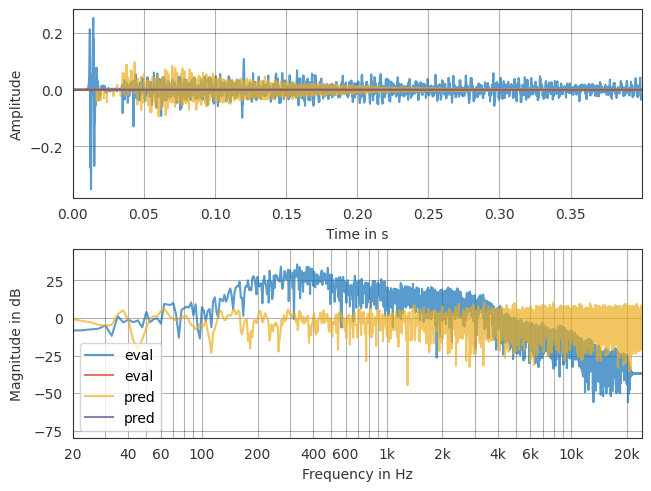

't = np.arange(len(pred_np)) / sr\n\nplt.plot(t, 20*np.log10(np.abs(eval_np)), label="ground truth IR", alpha=0.7)\nplt.plot(t, 20*np.log10(np.abs(pred_np)), label="FDN prediction", alpha=0.7)\n#plt.plot(t, eval_np, label="ground truth IR", alpha=0.5)\n#plt.plot(t, pred_np, label="FDN prediction", alpha=0.5)\nplt.xlabel("Time [s]")\nplt.ylabel("Amplitude [dB]")\nplt.ylim(-100, 0)          # typical IR dynamic range\nplt.grid(True, which="both", alpha=0.3)\nplt.legend()'

In [33]:
pred = util.normalize(pred)
pred_np = pred.squeeze(0).detach().cpu().numpy()
eval_np = eval_ir.squeeze(0).detach().cpu().numpy()
print(f"pred.shape: {pred.shape}")
print(f"eval_ir.shape: {eval_ir.shape}")

times = np.zeros(len(pred_np))
eval_sig = pf.Signal([eval_np.flatten(),times.flatten()],sampling_rate=model_sr)
pred_sig = pf.Signal([pred_np.flatten(),times.flatten()],sampling_rate=model_sr)

pf.plot.time_freq(eval_sig, label="eval", alpha=0.7)
pf.plot.time_freq(pred_sig, label="pred", alpha=0.7)
plt.legend()
plt.show()

"""t = np.arange(len(pred_np)) / sr

plt.plot(t, 20*np.log10(np.abs(eval_np)), label="ground truth IR", alpha=0.7)
plt.plot(t, 20*np.log10(np.abs(pred_np)), label="FDN prediction", alpha=0.7)
#plt.plot(t, eval_np, label="ground truth IR", alpha=0.5)
#plt.plot(t, pred_np, label="FDN prediction", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [dB]")
plt.ylim(-100, 0)          # typical IR dynamic range
plt.grid(True, which="both", alpha=0.3)
plt.legend()"""